[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving NEP_2020_english_tweet.csv to NEP_2020_english_tweet.csv
Original shape: (18240, 7)


,Unnamed: 0,Author_ID,Date_of_tweet,Tweet,Likes_on_tweet,User_handle,Tweet_link
0,0,60483175,2020-08-04 23:31:59+00:00,Historically #TamilNadu has been a state with ...,1,venkattcv,https://twitter.com/venkattcv/status/129079263...
1,1,1178900491595636736,2020-08-04 23:31:56+00:00,#HelloStrangerEP6 #HarrisonFord #GeorgeFloyd #...,0,BethEYoung3,https://twitter.com/BethEYoung3/status/1290792...
2,2,1072481505090318341,2020-08-04 22:22:30+00:00,@cbseindia29 @PMOIndia @narendramodi @DrRPNish...,1,PatelPrerak18,https://twitter.com/PatelPrerak18/status/12907...
3,3,583518901,2020-08-04 22:20:56+00:00,@PMOIndia’s anti-democratic #NEP2020 was 400+ ...,1,kchongpacrim,https://twitter.com/kchongpacrim/status/129077...
4,4,36339871,2020-08-04 21:01:14+00:00,The latest The Nursing Education Daily! http:/...,0,SkyscapeInc,https://twitter.com/SkyscapeInc/status/1290754...


Using text column: Tweet
After cleaning: (6858, 2)
Label distribution:
sentiment
neutral     3438
positive    2812
negative     608
Name: count, dtype: int64


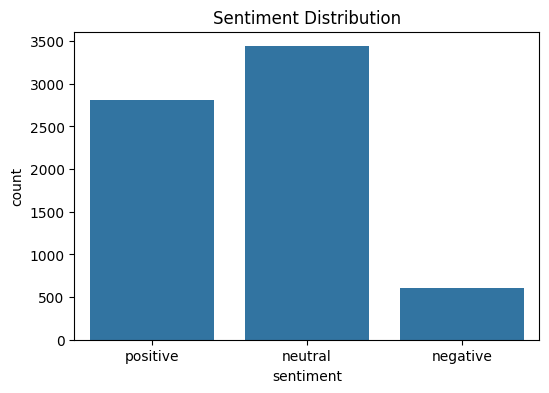

Balanced training data:
sentiment
positive    2750
neutral     2750
negative    2750
Name: count, dtype: int64

Training LogisticRegression...
LogisticRegression - Accuracy: 0.7201 | Precision: 0.6475 | Recall: 0.6363 | F1: 0.6414
              precision    recall  f1-score   support

    negative       0.45      0.41      0.43       122
     neutral       0.74      0.76      0.75       688
    positive       0.75      0.74      0.74       562

    accuracy                           0.72      1372
   macro avg       0.65      0.64      0.64      1372
weighted avg       0.72      0.72      0.72      1372



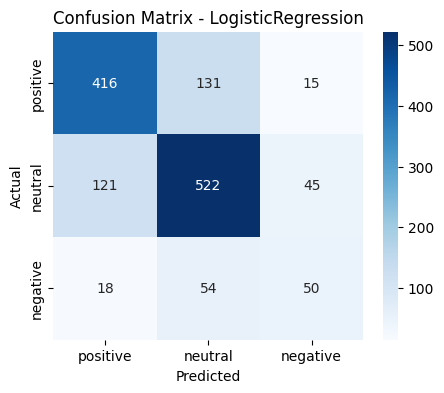


Training SVM...
SVM - Accuracy: 0.7143 | Precision: 0.6613 | Recall: 0.6096 | F1: 0.6270
              precision    recall  f1-score   support

    negative       0.53      0.33      0.41       122
     neutral       0.72      0.77      0.74       688
    positive       0.73      0.73      0.73       562

    accuracy                           0.71      1372
   macro avg       0.66      0.61      0.63      1372
weighted avg       0.71      0.71      0.71      1372



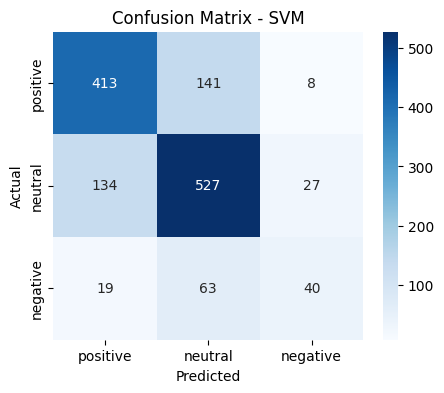


Training NaiveBayes...
NaiveBayes - Accuracy: 0.6786 | Precision: 0.6080 | Recall: 0.5874 | F1: 0.5955
              precision    recall  f1-score   support

    negative       0.43      0.34      0.38       122
     neutral       0.71      0.70      0.70       688
    positive       0.69      0.72      0.70       562

    accuracy                           0.68      1372
   macro avg       0.61      0.59      0.60      1372
weighted avg       0.67      0.68      0.68      1372



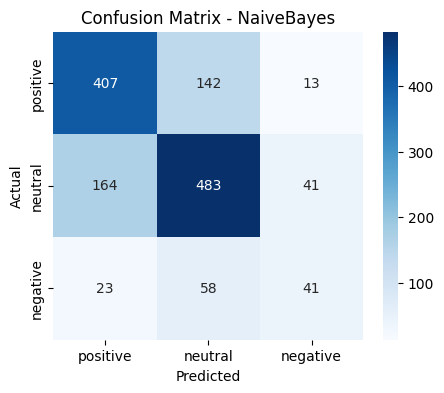


Model Comparison:


,Model,Accuracy,Precision,Recall,F1_macro
0,LogisticRegression,0.720117,0.647475,0.636257,0.641425
1,SVM,0.714286,0.661315,0.609578,0.627046
2,NaiveBayes,0.678571,0.607979,0.587433,0.595543


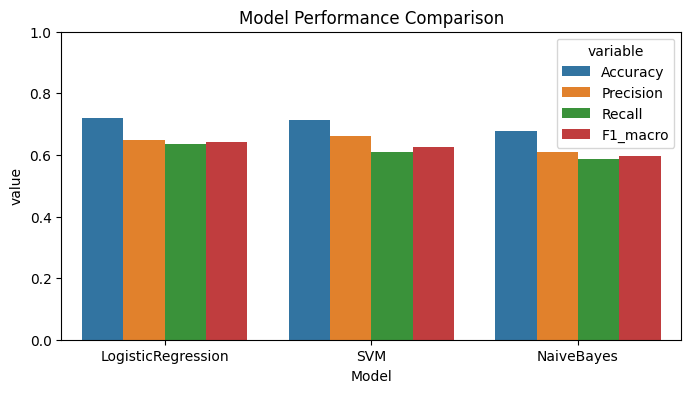


Example predictions:
'NEP is a great step forward for our education system.' -> positive
'This policy ignores rural needs and is disappointing.' -> negative
'I am not sure how this will affect college admissions.' -> negative


In [1]:
# -------------------------------
# Education Policy Sentiment Analysis (Classical ML)
# Models: Logistic Regression, SVM, Naive Bayes
# Fixed: sentiment bias, class imbalance, TF-IDF loading
# -------------------------------

# Install dependencies (Colab)
!pip install -q pandas numpy matplotlib seaborn scikit-learn nltk joblib

import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# -------------------------------
# 1. Load dataset
# -------------------------------
from google.colab import files
uploaded = files.upload()   # Upload NEP_2020_english_tweet.csv

DATA_PATH = list(uploaded.keys())[0]
df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)
display(df.head())

# -------------------------------
# 2. Identify text column
# -------------------------------
text_candidates = [c for c in df.columns if c.lower() in ('tweet','text','tweet_text','content','message')]
text_col = text_candidates[0] if text_candidates else df.select_dtypes(include='object').columns[0]
print("Using text column:", text_col)

df = df[[text_col]].rename(columns={text_col: 'text'}).dropna().drop_duplicates().reset_index(drop=True)

# -------------------------------
# 3. Clean text
# -------------------------------
STOPWORDS_NLTK = set(stopwords.words('english'))
ALL_STOPWORDS = ENGLISH_STOP_WORDS.union(STOPWORDS_NLTK).union({'rt'})

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'] != ''].reset_index(drop=True)
print("After cleaning:", df.shape)

# -------------------------------
# 4. Labeling — Better-balanced VADER thresholds
# -------------------------------
sid = SentimentIntensityAnalyzer()
def vader_label(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.4: return 'positive'
    elif score <= -0.4: return 'negative'
    else: return 'neutral'

df['sentiment'] = df['clean_text'].apply(vader_label)

print("Label distribution:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment Distribution')
plt.show()

# -------------------------------
# 5. Split and balance data
# -------------------------------
X = df['clean_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})

# Upsample minority classes
max_size = train_df['sentiment'].value_counts().max()
balanced_df = pd.concat([
    resample(train_df[train_df.sentiment == label],
             replace=True,
             n_samples=max_size,
             random_state=42)
    for label in train_df.sentiment.unique()
])

X_train = balanced_df['text']
y_train = balanced_df['sentiment']

print("Balanced training data:")
print(y_train.value_counts())

# -------------------------------
# 6. TF-IDF Vectorization
# -------------------------------
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# -------------------------------
# 7. Train Models
# -------------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': LinearSVC(random_state=42),
    'NaiveBayes': MultinomialNB()
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"{name} - Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=['positive','neutral','negative'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive','neutral','negative'],
                yticklabels=['positive','neutral','negative'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1_macro': f1})
    joblib.dump(model, f"{name}_model.joblib")

# -------------------------------
# 8. Compare Models
# -------------------------------
results_df = pd.DataFrame(results).sort_values(by='F1_macro', ascending=False)
print("\nModel Comparison:")
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars='Model',
                                 value_vars=['Accuracy','Precision','Recall','F1_macro']),
            x='Model', y='value', hue='variable')
plt.ylim(0,1)
plt.title('Model Performance Comparison')
plt.show()

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
results_df.to_csv("model_comparison_results.csv", index=False)

# -------------------------------
# 9. Example Predictions (fixed)
# -------------------------------
def predict_sentiment(text, model_name='LogisticRegression'):
    model = joblib.load(f"{model_name}_model.joblib")
    vectorizer = joblib.load("tfidf_vectorizer.joblib")
    text_clean = clean_text(text)
    vec = vectorizer.transform([text_clean])
    return model.predict(vec)[0]

examples = [
    "NEP is a great step forward for our education system.",
    "This policy ignores rural needs and is disappointing.",
    "I am not sure how this will affect college admissions."
]

print("\nExample predictions:")
for ex in examples:
    print(f"'{ex}' -> {predict_sentiment(ex, 'LogisticRegression')}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving test.csv to test.csv
Original shape: (17197, 2)


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Using text column: tweet
After cleaning: (16130, 2)
Label distribution:
sentiment
neutral     7386
positive    6613
negative    2131
Name: count, dtype: int64


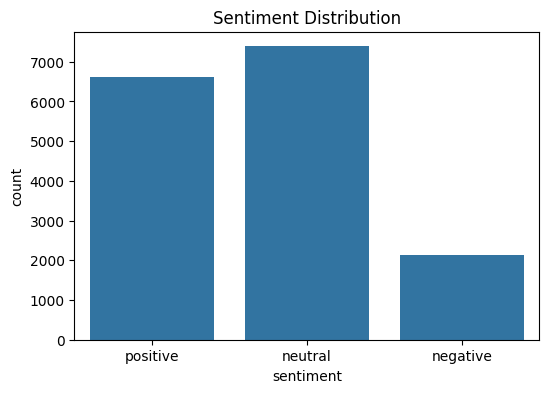

Balanced training data:
sentiment
positive    5909
negative    5909
neutral     5909
Name: count, dtype: int64

Training LogisticRegression...
LogisticRegression - Accuracy: 0.7948 | Precision: 0.7586 | Recall: 0.7784 | F1: 0.7661
              precision    recall  f1-score   support

    negative       0.60      0.72      0.66       426
     neutral       0.79      0.80      0.79      1477
    positive       0.89      0.81      0.85      1323

    accuracy                           0.79      3226
   macro avg       0.76      0.78      0.77      3226
weighted avg       0.80      0.79      0.80      3226



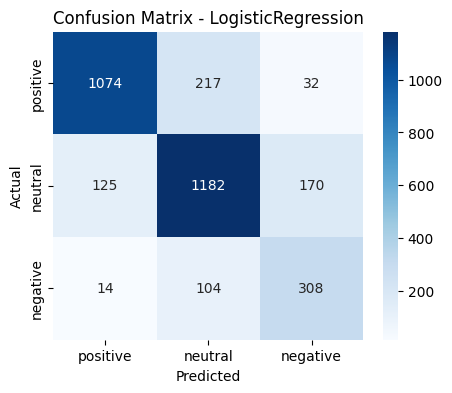


Training SVM...
SVM - Accuracy: 0.8007 | Precision: 0.7671 | Recall: 0.7793 | F1: 0.7727
              precision    recall  f1-score   support

    negative       0.64      0.70      0.67       426
     neutral       0.80      0.79      0.79      1477
    positive       0.86      0.84      0.85      1323

    accuracy                           0.80      3226
   macro avg       0.77      0.78      0.77      3226
weighted avg       0.80      0.80      0.80      3226



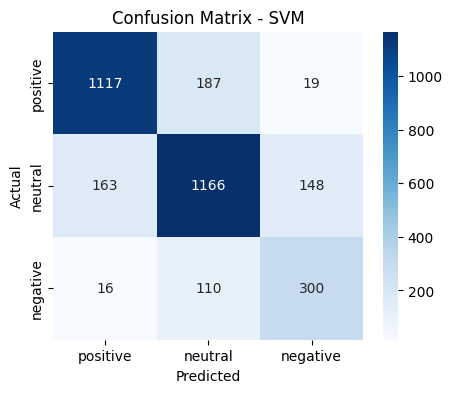


Training NaiveBayes...
NaiveBayes - Accuracy: 0.6990 | Precision: 0.6631 | Recall: 0.6810 | F1: 0.6684
              precision    recall  f1-score   support

    negative       0.53      0.60      0.57       426
     neutral       0.72      0.60      0.66      1477
    positive       0.73      0.84      0.78      1323

    accuracy                           0.70      3226
   macro avg       0.66      0.68      0.67      3226
weighted avg       0.70      0.70      0.70      3226



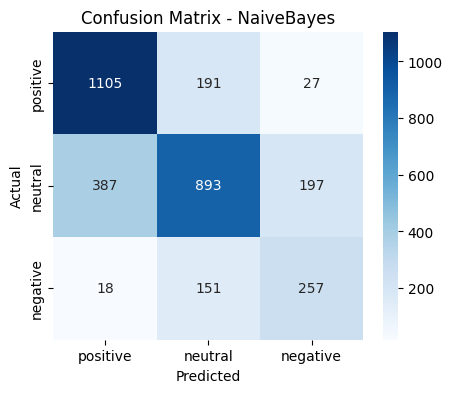


Model Comparison:


,Model,Accuracy,Precision,Recall,F1_macro
1,SVM,0.800682,0.767091,0.779319,0.772696
0,LogisticRegression,0.794792,0.758586,0.778356,0.766137
2,NaiveBayes,0.699008,0.663056,0.681038,0.668450


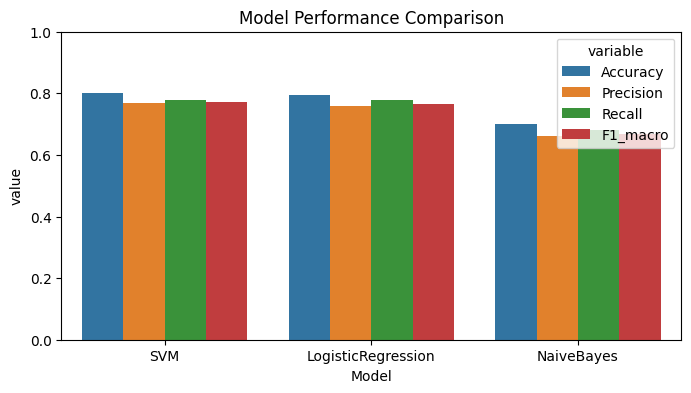


Example predictions:
'NEP is a great step forward for our education system.' -> positive
'This policy ignores rural needs and is disappointing.' -> negative
'I am not sure how this will affect college admissions.' -> neutral


In [2]:
# -------------------------------
# Education Policy Sentiment Analysis (Classical ML)
# Models: Logistic Regression, SVM, Naive Bayes
# Fixed: sentiment bias, class imbalance, TF-IDF loading
# -------------------------------

# Install dependencies (Colab)
!pip install -q pandas numpy matplotlib seaborn scikit-learn nltk joblib

import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# -------------------------------
# 1. Load dataset
# -------------------------------
from google.colab import files
uploaded = files.upload()   # Upload NEP_2020_english_tweet.csv

DATA_PATH = list(uploaded.keys())[0]
df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)
display(df.head())

# -------------------------------
# 2. Identify text column
# -------------------------------
text_candidates = [c for c in df.columns if c.lower() in ('tweet','text','tweet_text','content','message')]
text_col = text_candidates[0] if text_candidates else df.select_dtypes(include='object').columns[0]
print("Using text column:", text_col)

df = df[[text_col]].rename(columns={text_col: 'text'}).dropna().drop_duplicates().reset_index(drop=True)

# -------------------------------
# 3. Clean text
# -------------------------------
STOPWORDS_NLTK = set(stopwords.words('english'))
ALL_STOPWORDS = ENGLISH_STOP_WORDS.union(STOPWORDS_NLTK).union({'rt'})

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'] != ''].reset_index(drop=True)
print("After cleaning:", df.shape)

# -------------------------------
# 4. Labeling — Better-balanced VADER thresholds
# -------------------------------
sid = SentimentIntensityAnalyzer()
def vader_label(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.4: return 'positive'
    elif score <= -0.4: return 'negative'
    else: return 'neutral'

df['sentiment'] = df['clean_text'].apply(vader_label)

print("Label distribution:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment Distribution')
plt.show()

# -------------------------------
# 5. Split and balance data
# -------------------------------
X = df['clean_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})

# Upsample minority classes
max_size = train_df['sentiment'].value_counts().max()
balanced_df = pd.concat([
    resample(train_df[train_df.sentiment == label],
             replace=True,
             n_samples=max_size,
             random_state=42)
    for label in train_df.sentiment.unique()
])

X_train = balanced_df['text']
y_train = balanced_df['sentiment']

print("Balanced training data:")
print(y_train.value_counts())

# -------------------------------
# 6. TF-IDF Vectorization
# -------------------------------
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# -------------------------------
# 7. Train Models
# -------------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': LinearSVC(random_state=42),
    'NaiveBayes': MultinomialNB()
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"{name} - Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=['positive','neutral','negative'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive','neutral','negative'],
                yticklabels=['positive','neutral','negative'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1_macro': f1})
    joblib.dump(model, f"{name}_model.joblib")

# -------------------------------
# 8. Compare Models
# -------------------------------
results_df = pd.DataFrame(results).sort_values(by='F1_macro', ascending=False)
print("\nModel Comparison:")
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars='Model',
                                 value_vars=['Accuracy','Precision','Recall','F1_macro']),
            x='Model', y='value', hue='variable')
plt.ylim(0,1)
plt.title('Model Performance Comparison')
plt.show()

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
results_df.to_csv("model_comparison_results.csv", index=False)

# -------------------------------
# 9. Example Predictions (fixed)
# -------------------------------
def predict_sentiment(text, model_name='LogisticRegression'):
    model = joblib.load(f"{model_name}_model.joblib")
    vectorizer = joblib.load("tfidf_vectorizer.joblib")
    text_clean = clean_text(text)
    vec = vectorizer.transform([text_clean])
    return model.predict(vec)[0]

examples = [
    "NEP is a great step forward for our education system.",
    "This policy ignores rural needs and is disappointing.",
    "I am not sure how this will affect college admissions."
]

print("\nExample predictions:")
for ex in examples:
    print(f"'{ex}' -> {predict_sentiment(ex, 'LogisticRegression')}")
